In [1]:
# Random Imports
import os
import sys
import yaml
from pathlib import Path
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSegDev')

# Regular schema dictates that we put DATAPATH
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ['WANDB_NOTEBOOK_NAME'] = 'train.ipynb'

# IonPy imports
from ionpy.util import Config

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
%%yaml default_cfg 

experiment:
  seed: '?' 
    
dataloader:
  batch_size: '?' 
  num_workers: 1 
  pin_memory: True 

optim: 
  _class: torch.optim.Adam
  lr: '?'
  
train:
  epochs: '?' 
  eval_freq: '?'

# Used for additional data experiment.
data:
  train_splits: train
  val_splits: val
  
loss_func: 
  _class: '?'
  from_logits: True
  batch_reduction: 'mean' 

<IPython.core.display.Javascript object>

In [3]:
%%yaml log_cfg

log:
  root: '?'
  checkpoint_freq: 20 
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      batch_reduction: 'mean' 
      ignore_empty_labels: False 
      from_logits: True
    ece_loss:
      _fn: ese.metrics.image_ece_loss
      num_prob_bins: 15
      from_logits: True

<IPython.core.display.Javascript object>

In [4]:
%%yaml model_cfg  

model:
  _class: ese.models.unet.UNet
  filters: '?'
  convs_per_block: '?' # Good default for UNets.

<IPython.core.display.Javascript object>

In [5]:
%%yaml callbacks_cfg

callbacks:
  step:
    - ese.callbacks.ShowPredictions
  epoch:
    - ese.callbacks.WandbLogger
    - ionpy.callbacks.ETA
    - ionpy.callbacks.JobProgress
    - ionpy.callbacks.TerminateOnNaN
    - ionpy.callbacks.PrintLogged
    - ionpy.callbacks.ModelCheckpoint:
        monitor: dice_score
        phase: val

<IPython.core.display.Javascript object>

In [6]:
%%yaml experiment_cfg 

name: "ISLES_3D_Pilot"

# # SVLS 
# augmentations:
#     train:
#         - ese.augmentation.SVLS:
#             ksize: 3
#             sigma: 1
#             always_apply: True
#             include_center: True 

experiment:
    seed: 40
    seed_range: 4

## Setup for UniverSeg datasets.
data:
    _class: "ese.datasets.ISLES"
    # version: 0.1 # 2D version
    version: 1.0 # 3D version

dataloader:
  batch_size: 1

model:
    convs_per_block: 2
    dims: 3

loss_func:
    _class: 
        - ese.losses.SoftDiceLoss
        - ese.losses.PixelCELoss

<IPython.core.display.Javascript object>

In [7]:
from ese.analysis.analysis_utils.submit_utils import get_ese_training_configs 

# Get the configs for the different runs.
base_cfg = Config(default_cfg).update([model_cfg, log_cfg, callbacks_cfg])

# Get the different experiment cfg yamls.
updated_base_cfg, train_cfgs = get_ese_training_configs(
    exp_cfg=experiment_cfg, 
    base_cfg=base_cfg
)

In [8]:
len(train_cfgs)

8

In [9]:
from pprint import pprint

pprint(train_cfgs[0])

Config({'experiment': {'seed': 40}, 'dataloader': {'batch_size': 1, 'num_workers': 1, 'pin_memory': True}, 'optim': {'_class': 'torch.optim.Adam', 'lr': 0.0001}, 'train': {'epochs': 1000, 'eval_freq': 10}, 'data': {'train_splits': 'train', 'val_splits': 'val', '_class': 'ese.datasets.ISLES', 'in_channels': 1, 'out_channels': 1, 'version': 1.0, 'preload': False}, 'loss_func': {'_class': 'ese.losses.SoftDiceLoss', 'from_logits': True, 'batch_reduction': 'mean'}, 'model': {'_class': 'ese.models.unet.UNet', 'filters': [64, 64, 64, 64, 64], 'convs_per_block': 2, 'dims': 3}, 'log': {'root': '/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_Pilot', 'checkpoint_freq': 20, 'metrics': {'dice_score': {'_fn': 'ionpy.metrics.dice_score', 'batch_reduction': 'mean', 'ignore_empty_labels': False, 'from_logits': True}, 'ece_loss': {'_fn': 'ese.metrics.image_ece_loss', 'num_prob_bins': 15, 'from_logits': True}, 'edge_ece_loss': {'_fn': 'ese.metrics.image_edge_ece_loss', 'num_prob_bins': 15, 'neigh

## Running Jobs

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Set seed: 40


Intel MKL extensions not available for NumPy

Using slow Pillow instead of Pillow-SIMD

Running CalibrationExperiment("/storage/vbutoi/scratch/ESE/training/debug/20240908_211929-3RF3-951348b3f861060749796fd0d358f9c4")
---
callbacks:
  epoch:
  - ionpy.callbacks.ETA
  - ionpy.callbacks.JobProgress
  - ionpy.callbacks.TerminateOnNaN
  - ionpy.callbacks.PrintLogged
  - ionpy.callbacks.ModelCheckpoint:
      monitor: dice_score
      phase: val
  step:
  - ese.callbacks.ShowPredictions
data:
  _class: ese.datasets.ISLES
  preload: false
  train_splits: train
  val_splits: val
  version: 1.0
dataloader:
  batch_size: 1
  num_workers: 1
  pin_memory: true
experiment:
  seed: 40
log:
  checkpoint_freq: 20
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      batch_reduction: mean
      from_logits: true
      ignore_empty_labels: false
    ece_loss:
      _fn: ese.metrics.image_ece_loss
      from_logits: true
      num_prob_bins: 15
    edge_ece_loss:
      _fn: ese.metrics.image_edge_ece_loss
      from_logits: true
      neighborhood_width: 3
      num_prob_bin

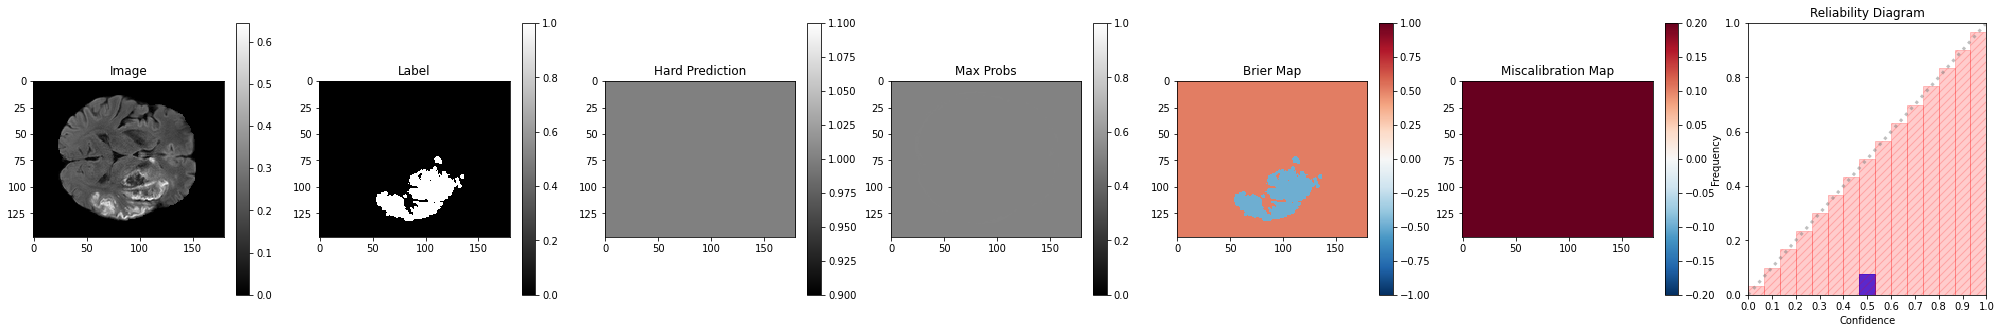

looking at shapes
torch.Size([1, 1, 148, 180, 71]) torch.Size([1, 148, 180, 71])


AssertionError: After prep, y_pred and y_true must be 4D and 3D tensors, respectively. Got torch.Size([1, 1, 148, 180, 71]) and torch.Size([1, 148, 180, 71]).

In [10]:
####### FOR DEBUGGIN
from ese.experiment import run_ese_exp, CalibrationExperiment

run_ese_exp(
    config=train_cfgs[0], 
    experiment_class=CalibrationExperiment,
    gpu='0',
    # gpu='4',
    run_name='debug',
    show_examples=True,
    track_wandb=False
)

In [ ]:
# FOR SUBMISSION
from ese.experiment import submit_ese_exps, CalibrationExperiment 

submit_ese_exps(
    group="training",
    base_cfg=updated_base_cfg,
    exp_cfg=experiment_cfg,
    config_list=train_cfgs,
    experiment_class=CalibrationExperiment,
    available_gpus=['0', '1', '2', '3'],
    # available_gpus=['4', '5', '6', '7'],
    track_wandb=True
)